#Levanto data set preprocesado

In [ ]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import seaborn as sbn
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
from gensim.models.phrases import Phrases, Phraser
import multiprocessing
from gensim.models import Word2Vec

from google.colab import drive
drive.mount('/content/drive')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


Mounted at /content/drive


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
directory = '/content/drive/My Drive/DatosTP/limp'
df = pd.read_pickle('/content/drive/My Drive/DatosTP/limp1.pickle')
for i in range(2,14):
  path = directory + str(i) + '.pickle'
  df1 = pd.read_pickle(path)
  df = df.append(df1)

##Filtro la información clasificable y la convierto a modelos binarios

Podría iterar una vez más y predecir el valor de las que dan 3 para separarlas para un lado y para el otro, y usar así el modelo para compararlos entre sí

In [ ]:
df['raicesjuntas'] = df['raicesl'].apply(" ".join)
df['raicesjuntas'] = df['raicesjuntas'].str.replace('__','')
df['raicesjuntas'] = df['raicesjuntas'].str.replace(' ˆø ',' ')

In [ ]:
def hago_binaria(numero):
  if numero == 4 or numero == 5:
    return 1
  else:
    return 0

In [ ]:
#nltk.download('stopwords')

#stopwords = nltk.corpus.stopwords.words('english')

Armo nuevos df con los datos con cohesion y lucidez binarias

In [ ]:
#dfl = df[((df['lucidity']!=-1))]
#dfl = dfl[dfl['lucidity']!= 3]
#dfl.shape

In [ ]:
#dfl['lucidityb'] = dfl['lucidity'].apply(hago_binaria)

In [ ]:
#df.columns

In [ ]:
#dfc = df[((df['cohesion']!=-1))]
#dfc = dfc[dfc['cohesion']!= 3]
#dfc.shape

In [ ]:
#dfc['cohesionb'] = dfc['cohesion'].apply(hago_binaria)

In [ ]:
dflc = df[((df['lucidity']!=-1))]
dflc = dflc[dflc['cohesion'] != -1]
dflc = dflc[dflc['cohesion'] != 3]
dflc = dflc[dflc['lucidity'] != 3]
dflc.shape
#18234 sueños

(18234, 16)

In [ ]:
dflc['cohesionb'] = dflc['cohesion'].apply(hago_binaria)

In [ ]:
dflc['lucidityb'] = dflc['lucidity'].apply(hago_binaria)

##Separo set y train y aplico a cada uno los ajustes correspondientes
Las raices ya están lemmatizadas

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [ ]:
train, test = train_test_split(dflc, test_size=0.3, random_state=22)

In [ ]:
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
#from gensim.models import Word2Vec

##cohesion


In [ ]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

train_taggedc = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['raicesjuntas']), tags=[r.cohesionb]), axis=1)
test_taggedc = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['raicesjuntas']), tags=[r.cohesionb]), axis=1)

In [ ]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [ ]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re

In [ ]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0)
model_dbow.build_vocab([x for x in train_taggedc.values])

In [ ]:
for epoch in range(3):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_taggedc.values)]), total_examples=len(train_taggedc.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 12763/12763 [00:00<00:00, 1265350.11it/s]


In [ ]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
y_train, X_train = vec_for_learning(model_dbow, train_taggedc)
y_test, X_test = vec_for_learning(model_dbow, test_taggedc)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
probas = logreg.predict_proba(X_test)

In [ ]:
from sklearn.metrics import roc_curve # función curva ROC de scikit-learn
from sklearn.metrics import roc_auc_score # función AUC de scikit-learn

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, probas[:,1]) # Función ROC: recibe las etiquetas verdaderas y las probas de que sean 1
                                                # Devuelve las tastas de falsos positivos y verdaderos positivos, además de los
                                                # umbrales a los que están calculados
auc = roc_auc_score(y_test, probas[:,1]) # Cálculo del área debajo de la curva, recibe también las etiquetas verdaderas
                                    # y la proba de que valgan 1.

print('AUC: {}'.format(round(auc,4))) # mostramos el AUC con 4 cifras significativas


AUC: 0.6704


In [ ]:
from numpy.random import shuffle # para shufflear el vector

y_shuffledt = list(y_train) # creo una copia del vector de targets, porque shuffle lo pisa
shuffle(y_shuffledt) # shuffleo

y_shuffledtst = list(y_test) # creo una copia del vector de targets, porque shuffle lo pisa
shuffle(y_shuffledtst) # shuffleo

logreg2 = LogisticRegression(n_jobs=1, C=1e5)
logreg2.fit(X_train, y_shuffledt)
y_pred2 = logreg2.predict(X_test)

probas2 = logreg2.predict_proba(X_test)
pr2, tpr2, thresholds2 = roc_curve(y_shuffledtst, probas2[:,1])
auc_test2 = roc_auc_score(y_shuffledtst, probas2[:,1]) #  AUC con datos de evaluación

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


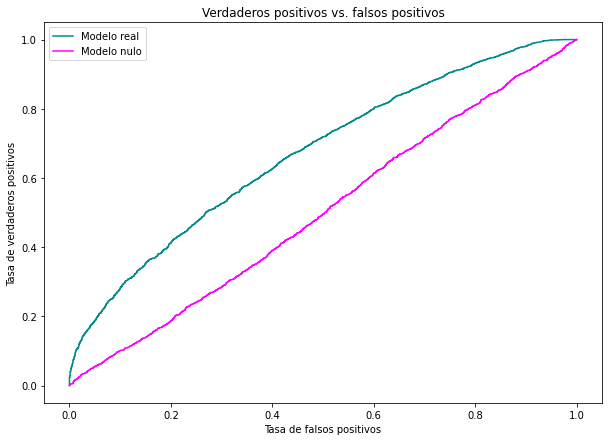

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# este codigo fue sacado del notebook de ROC AUC (clase 10) y sirve para visualizar la curva ROC

fig, ax = plt.subplots(figsize = (10,7))
ax.set_title('Verdaderos positivos vs. falsos positivos')
ax.plot(fpr,tpr, label='Modelo real', color='darkcyan')
ax.plot(pr2,tpr2, label='Modelo nulo', color = 'magenta')

ax.set_xlabel('Tasa de falsos positivos') # Etiqueta del eje x
ax.set_ylabel('Tasa de verdaderos positivos') # Etiqueta del eje y
plt.legend()

In [ ]:
from sklearn.metrics import roc_auc_score

y_hat_test = logreg.predict_proba(X_test)[:, 1]
y_hat_train = logreg.predict_proba(X_train)[:, 1]

# evaluo el AUC
roc_test = roc_auc_score(y_test, y_hat_test)
roc_train = roc_auc_score(y_train, y_hat_train)
roc_test, roc_train

(0.6703874235826053, 0.7175769198720169)

In [ ]:
from sklearn.metrics import confusion_matrix

def TPR_FPR(cm): # computa la tasa de verdaderos y falsos positivos a partir de la matriz de confusion
  TPR = cm[1,1]/(cm[1,1]+cm[0,1])
  FPR = cm[1,0]/(cm[1,0]+cm[0,0])
  return [TPR,FPR] # devuelve una lista donde el primer elemento es la tasa de verdaderos positivos y el segundo la tasa de falsos negativos

T = 0.5 # definimos el umbral
ypred = np.zeros(probas.shape[0]) # armamos un vector que tiene todos ceros y tiene la longitud del vector de etiquetas
ypred[probas[:,1]>T] = 1 # donde la probabilidad es mayor que T, ponemos 1
cm = confusion_matrix(ypred, y_test) # metemos en la matriz de confusion
metricas = TPR_FPR(cm)

print('Matriz de confusion del modelo es:')
print(cm)
print('Tasa de verdaderos positivos: {}'.format(round(metricas[0],4)))
print('Tasa de falsos positivos: {}'.format(round(metricas[1],4)))

###lucidez

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
train_taggedl = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['raicesjuntas']), tags=[r.lucidityb]), axis=1)
test_taggedl = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['raicesjuntas']), tags=[r.lucidityb]), axis=1)

In [ ]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [ ]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0)
model_dbow.build_vocab([x for x in train_taggedl.values])

In [ ]:
for epoch in range(3):
    model_dbow.train(utils.shuffle([x for x in train_taggedl.values]), total_examples=len(train_taggedl.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [ ]:
y_train, X_train = vec_for_learning(model_dbow, train_taggedl)
y_test, X_test = vec_for_learning(model_dbow, test_taggedl)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
probas = logreg.predict_proba(X_test)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, probas[:,1]) # Función ROC: recibe las etiquetas verdaderas y las probas de que sean 1
                                                # Devuelve las tastas de falsos positivos y verdaderos positivos, además de los
                                                # umbrales a los que están calculados
auc = roc_auc_score(y_test, probas[:,1]) # Cálculo del área debajo de la curva, recibe también las etiquetas verdaderas
                                    # y la proba de que valgan 1.

print('AUC: {}'.format(round(auc,4))) # mostramos el AUC con 4 cifras significativas


AUC: 0.7669


In [ ]:
from numpy.random import shuffle # para shufflear el vector

y_shuffledt = list(y_train) # creo una copia del vector de targets, porque shuffle lo pisa
shuffle(y_shuffledt) # shuffleo

y_shuffledtst = list(y_test) # creo una copia del vector de targets, porque shuffle lo pisa
shuffle(y_shuffledtst) # shuffleo

logreg2 = LogisticRegression(n_jobs=1, C=1e5)
logreg2.fit(X_train, y_shuffledt)
y_pred2 = logreg2.predict(X_test)

probas2 = logreg2.predict_proba(X_test)
pr2, tpr2, thresholds2 = roc_curve(y_shuffledtst, probas2[:,1])
auc_test2 = roc_auc_score(y_shuffledtst, probas2[:,1]) #  AUC con datos de evaluación

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


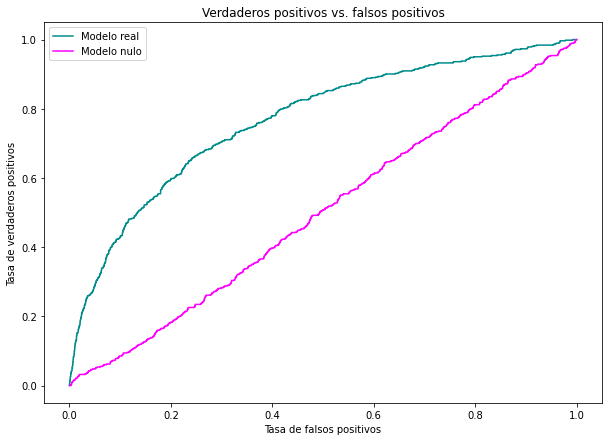

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# este codigo fue sacado del notebook de ROC AUC (clase 10) y sirve para visualizar la curva ROC

fig, ax = plt.subplots(figsize = (10,7))
ax.set_title('Verdaderos positivos vs. falsos positivos')
ax.plot(fpr,tpr, label='Modelo real', color='darkcyan')
ax.plot(pr2,tpr2, label='Modelo nulo', color = 'magenta')

ax.set_xlabel('Tasa de falsos positivos') # Etiqueta del eje x
ax.set_ylabel('Tasa de verdaderos positivos') # Etiqueta del eje y
plt.legend()

In [ ]:
from sklearn.metrics import roc_auc_score

y_hat_test = logreg.predict_proba(X_test)[:, 1]
y_hat_train = logreg.predict_proba(X_train)[:, 1]

# evaluo el AUC
roc_test = roc_auc_score(y_test, y_hat_test)
roc_train = roc_auc_score(y_train, y_hat_train)
roc_test, roc_train

(0.766883661141197, 0.8263520443828305)

In [ ]:
from sklearn.metrics import confusion_matrix

def TPR_FPR(cm): # computa la tasa de verdaderos y falsos positivos a partir de la matriz de confusion
  TPR = cm[1,1]/(cm[1,1]+cm[0,1])
  FPR = cm[1,0]/(cm[1,0]+cm[0,0])
  return [TPR,FPR] # devuelve una lista donde el primer elemento es la tasa de verdaderos positivos y el segundo la tasa de falsos negativos

T = 0.5 # definimos el umbral
ypred = np.zeros(probas.shape[0]) # armamos un vector que tiene todos ceros y tiene la longitud del vector de etiquetas
ypred[probas[:,1]>T] = 1 # donde la probabilidad es mayor que T, ponemos 1
cm = confusion_matrix(ypred, y_test) # metemos en la matriz de confusion
metricas = TPR_FPR(cm)

print('Matriz de confusion del modelo es:')
print(cm)
print('Tasa de verdaderos positivos: {}'.format(round(metricas[0],4)))
print('Tasa de falsos positivos: {}'.format(round(metricas[1],4)))

Matriz de confusion del modelo es:
[[4838  482]
 [  70   81]]
Tasa de verdaderos positivos: 0.1439
Tasa de falsos positivos: 0.0143


TO DO SVD PREDICTER U OTRO MODELO DE PREDICCIONES  
NORMALIZAR